# Matrix Factorization 3

사용자의 1 건의 이전 시청 이력에서 여러 건의 시청 이력을 반영하여 보다 정확도를 높혀 봅니다.

1. 시청 이력과 같은 순차 데이터를 모델링하는 신경망 모델을 알아 봅니다.

2. 시청 이력을 평점 이력 마다 이전 시청 이력을 처리하기 위한 데이터 스트리밍 루틴을 구현합니다.

3. Tensorflow Custom Train 기법으로 데이터 스트리밍으로 생성이 되는 데이터를 학습해봅니다.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from IPython.display import clear_output

import gdown
%load_ext tensorboard

2025-09-24 08:03:50.223459: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758701030.268207   18817 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758701030.277031   18817 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758701030.307540   18817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758701030.307580   18817 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758701030.307583   18817 computation_placer.cc:177] computation placer alr

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1758701035.770079   18817 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6715 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1


# MovieLens32M 데이터 준비

In [3]:
# MovieLens32M 데이터 처리 모듈을 불러옵니다. (Matrix Factorization2에서의 처리 과정을 모듈로 만들었습니다.)
import movielens32m

m32m = movielens32m.load_dataset('dataset') # dataset 경로에 있는 movielens32m 데이터를 불러옵니다.
[i for i in m32m.keys()]

['movie_info_kr', 'movie', 'genre', 'series', 'ratings', 'movieinfo']

In [5]:
df_ratings = m32m['ratings']
s_series = m32m['series']
s_genre = m32m['genre']
df_movie = m32m['movie']
df_movieinfo = m32m['movieinfo']

In [22]:
# 사용자의 이전 시점의 평가 이력을 입력 변수로 사용하기 위해
# 시점별로 정렬을 하여, 사용자 별로 시청했던 이력을 시점별로 np.array로 저장합니다.
# 시점별 정렬은 시점을 기준으로 이진 검색을 위함입니다.
df_user_hist = df_ratings.sort_values('date').groupby('userId').agg(list).map(
    lambda x: np.array(x)
)

In [23]:
df_user_hist.head()

movieId  \
userId                                                      
1       [2997, 2966, 2890, 3078, 2882, 541, 838, 1136,...   
2       [592, 296, 380, 344, 153, 588, 349, 318, 231, ...   
3       [2012, 466, 2268, 168, 1544, 4306, 1485, 2617,...   
4       [1210, 1833, 2745, 1272, 2115, 1327, 2826, 268...   
5       [592, 150, 590, 380, 296, 349, 344, 165, 588, ...   

                                                   rating  \
userId                                                      
1       [4.0, 1.0, 4.0, 2.0, 1.0, 5.0, 5.0, 1.0, 5.0, ...   
2       [4.0, 1.0, 5.0, 1.0, 3.0, 5.0, 3.0, 5.0, 2.0, ...   
3       [3.0, 1.0, 4.0, 3.5, 4.0, 3.5, 4.0, 4.0, 3.5, ...   
4       [3.0, 2.0, 3.0, 4.0, 5.0, 3.0, 2.0, 3.0, 2.0, ...   
5       [4.0, 3.0, 3.0, 5.0, 1.0, 4.0, 3.0, 4.0, 3.0, ...   

                                                     date  \
userId                                                      
1       [1999-11-21 23:27:26, 1999-11-21 23:27:26, 199...   
2       [1996-07-03 19:46:41, 1996-07-03 19:46:42, 199...   
3       [2004-05-13 21:39:14, 2004-05-13 21:39:22, 200...   
4       [2000-06-08 17:27:14, 2000-06-08 17:27:14, 200...   
5       [1996-08-23 01:31:53, 1996-08-23 01:31:54, 199...   

                                                       ts  
userId                                                     
1       [943226846000000000, 943226846000000000, 94322...  
2       [836423201000000000, 836423202000000000, 83642...  
3       [1084484354000000000, 1084484362000000000, 108...  
4       [960485234000000000, 960485234000000000, 96048...  
5       [840763913000000000, 840763914000000000, 84076...

In [6]:
df_train = df_ratings.loc[df_ratings['date'] < '2022-10-13']
df_test = df_ratings.loc[df_ratings['date'] >= '2022-10-13']
len(df_train) / len(df_ratings), len(df_test) / len(df_ratings)

(0.9690947907707088, 0.030905209229291162)

In [7]:
rating_train_mean = df_train['rating'].astype('float64').mean()
s_userCnt = df_train['userId'].value_counts()
s_movieCnt = df_train['movieId'].value_counts()

In [8]:
import rcmd

# 다수의 시청이력 모델링

**사용자의 평가이력 모델을 업그레이드해봅니다.**

여러개의 이력에서 패턴을 뽑아 사용자 벡터를 만들어 내는 신경망 모델을 만듭니다.

## 순환 신경망

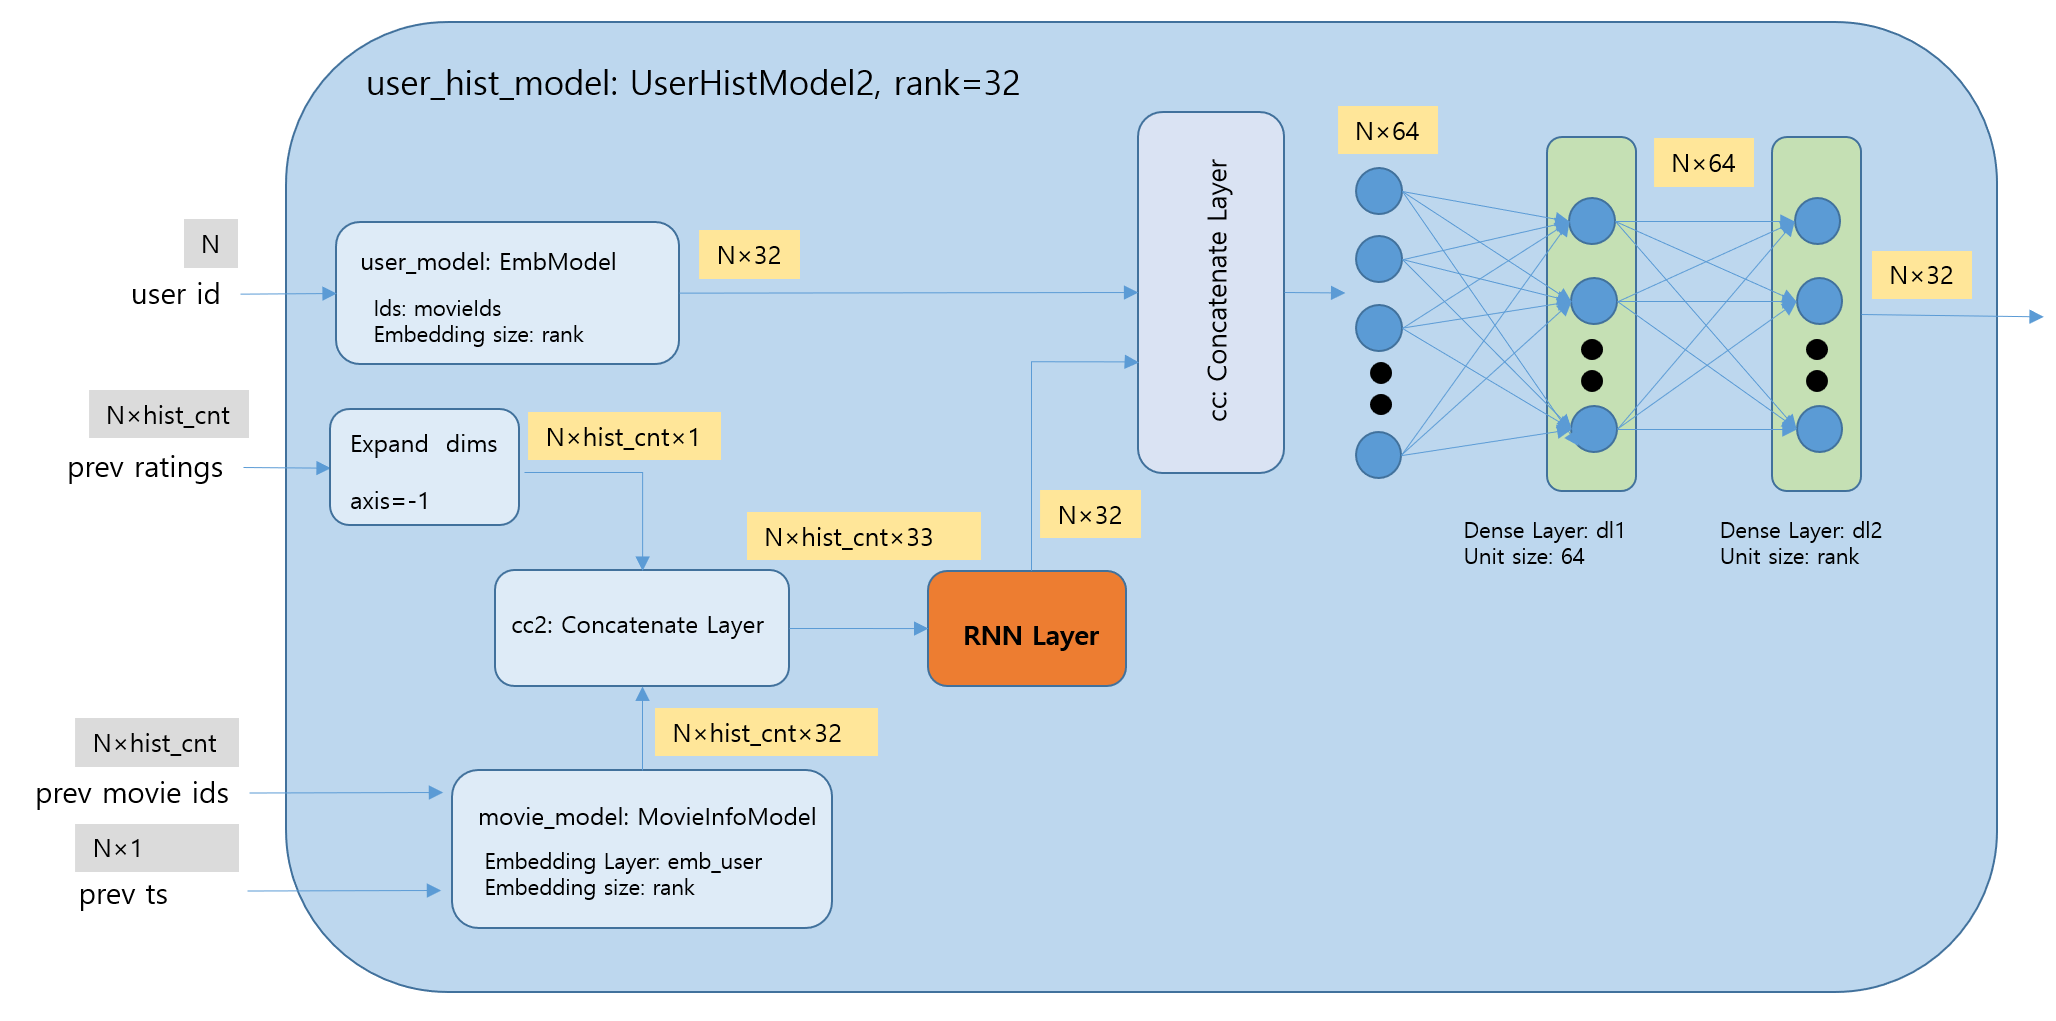

In [9]:
# UserHistModel2에서 평가 순서를 모델링하기 위한 RNN의 기능을 확인해봅니다. 
# 이를 통해 순서를 기반한 패턴을 모델링합니다.
rank = 32
collection_rank = 8
movie_model = rcmd.EmbModel(s_movieCnt.loc[s_movieCnt >= 100].index.values, rank)
movie_info_model = rcmd.MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)

In [10]:
# 3건의 영화 임베딩을 호출해봅니다.
# [1, 2, 3] 영화 평가 순서 Pattern을 뽑고 
# [3, 2, 5] 영화 평가 순서 Pattern을 뽑아
movie_info_model(tf.constant([[1, 2, 3], [3, 2, 5]]), tf.constant([[0, 0, 0], [0, 0, 0]], dtype = tf.int64))

<tf.Tensor: shape=(2, 3, 32), dtype=float32, numpy=
array([[[ 0.0406989 , -0.06847227,  0.02827982,  0.0172632 ,
         -0.04103119,  0.00553671,  0.04239796,  0.0015753 ,
          0.04008146, -0.02076504, -0.13915896, -0.11994343,
          0.05383721,  0.13837141, -0.08979417, -0.04310754,
          0.04437038,  0.05496954,  0.02016823, -0.10947268,
         -0.02784275,  0.01860463, -0.03129235, -0.0140727 ,
         -0.01102846, -0.02264556, -0.14323783, -0.00357732,
         -0.07547975,  0.04187776,  0.04399076,  0.00384622],
        [ 0.04435473, -0.02029638,  0.0495264 ,  0.05762041,
          0.02486135,  0.0283865 ,  0.0837123 , -0.05322242,
          0.01406456,  0.08834086, -0.049402  , -0.03827974,
          0.04317962,  0.03206223, -0.11045808, -0.00451693,
          0.01060226,  0.02546948, -0.06716646, -0.05264334,
          0.09508973,  0.09503722, -0.03014143, -0.00827461,
          0.09246881, -0.02580764, -0.06345745, -0.0198158 ,
          0.04250736, -0.0098052

In [11]:
# [1, 2] 영화 평가 순서 Pattern을 뽑고 
# [3, 2] 영화 평가 순서 Pattern을 뽑아
# [2, 2, 32]
# LSTM이라는 RNN을 사용합니다. 유닛수를 32로 설정합니다.
rnn = tf.keras.layers.LSTM(32)
# LSTM 출력 유닛으로 출력을 내어줍니다. [2, 32]
rnn(
    movie_info_model(tf.constant([[1, 2, 3], [3, 2, 5]]), tf.constant([[0, 0, 0], [0, 0, 0]], dtype = tf.int64))
)

I0000 00:00:1758701676.423073   18866 cuda_dnn.cc:529] Loaded cuDNN version 90300


<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[ 2.65293056e-03,  9.11267009e-03,  9.56176315e-03,
         1.29063036e-02,  7.53521547e-03,  8.18194542e-03,
         6.10459177e-03, -1.34899672e-02, -1.20679857e-02,
        -1.22713791e-02, -1.60665810e-02,  2.36889115e-03,
         1.08045642e-03,  5.69151109e-03, -2.01562271e-02,
        -1.01502798e-02,  4.55827601e-02, -1.18227731e-02,
         4.99001297e-04, -1.83010548e-02, -1.66989192e-02,
        -5.09085476e-05, -7.69955106e-03,  1.35254152e-02,
        -1.54869584e-02,  1.05106947e-03, -3.52649055e-02,
        -2.20731143e-02,  8.93908273e-03, -8.63154698e-03,
        -1.00367628e-02, -9.23540536e-03],
       [ 4.03649453e-03,  9.12047364e-03,  7.28756143e-03,
         1.17680905e-02,  1.14320852e-02, -1.21066645e-04,
         6.60787290e-03, -6.25016959e-03, -5.27312048e-03,
        -1.66864991e-02, -1.32162580e-02, -1.22058135e-03,
         6.76714396e-03,  1.16917640e-02, -1.68010462e-02,
        -1.83305901e-03

In [12]:
# 순서를 고려하지 않는다면, 평균을 내어 패턴을 뽑는 방법을 쓸 수 있습니다.
tf.reduce_mean(
    movie_info_model(tf.constant([[1, 2, 3], [3, 2, 5]]), tf.constant([[0, 0, 0], [0, 0, 0]], dtype = tf.int64)), axis = -2
)

<tf.Tensor: shape=(2, 32), dtype=float32, numpy=
array([[ 0.00289294, -0.03869643,  0.03559646,  0.01887955, -0.02826948,
         0.00589363,  0.05926375, -0.00557463,  0.0169524 ,  0.02116919,
        -0.087006  , -0.05160108,  0.06827185,  0.05878225, -0.09962014,
        -0.01517026,  0.00090778,  0.04283559, -0.00603955, -0.0736374 ,
         0.02209491,  0.05076994, -0.01479219, -0.01314994,  0.05622451,
        -0.04604902, -0.106767  , -0.04543948, -0.01512329,  0.04030914,
         0.00469534, -0.00584104],
       [-0.03617029, -0.0312867 ,  0.03818108,  0.01351174, -0.01956932,
        -0.02640222,  0.05315698, -0.00211265,  0.01234424,  0.01345759,
        -0.05820361, -0.02230047,  0.06947989,  0.02769651, -0.09544449,
        -0.00386857, -0.00056083,  0.03487774, -0.03018808, -0.06859592,
         0.0216103 ,  0.05346899, -0.02284796, -0.0252592 ,  0.06791579,
        -0.04624769, -0.07799818, -0.0582641 ,  0.00778293,  0.04687516,
        -0.00771633, -0.02304184]], dtyp

In [13]:
class UserHistModel2(tf.keras.Model):
    def __init__(self, user_model, movie_model, rank, l2 = 0, rnn = "lstm"):
        """
            user_model: EmbModel
                사용자 임베딩 모델
            movie_model: EmbModel
                영화 임베딩 모델
            rank: int
                출력 벡터의 사이즈
            l2: float
                l2 규제 계수
            rnn: str
                평가 이력 행렬을 통과시킬 RNN 종류: lstm - LSTM, gru - GRU, 그외는 RNN 미사용 평균
        """
        super().__init__()
        self.user_model = user_model
        self.movie_model = movie_model
        if rnn == "lstm":
            self.rnn = tf.keras.layers.LSTM(32)
        elif rnn == "gru":
            self.rnn = tf.keras.layers.GRU(32)
        else:
            self.rnn = None
        if l2 > 0:
            reg = tf.keras.regularizers.L2(l2)
        else:
            reg = None
        # 평가 이력 벡터와 사용자 벡터를 입력으로하는 은닉 밀도층
        # unit size: 64, activator: relu, kernel initializer: HeUniform
        self.dl = tf.keras.layers.Dense(
            64, activation='relu', 
            kernel_initializer=tf.keras.initializers.HeUniform(),
            kernel_regularizer=reg
        )
        # 출력 밀도레이어
        self.o = tf.keras.layers.Dense(
            rank,
            kernel_regularizer=reg
        )
        # 평가 영화 벡터와 평점을 결합시키기 위한 결합레이어
        self.cc = tf.keras.layers.Concatenate(axis=-1)
        # 평가 이력 벡터와 사용자 벡터를 결합시키기 위한 레이어
        self.cc2 = tf.keras.layers.Concatenate(axis=-1)
        
    def call(self, x, prev_movieIds, prev_ratings, prev_ts, training=False):
        hist_vec = self.cc([
            self.movie_model(prev_movieIds, prev_ts, training=training),
            prev_ratings
        ]) # N×?×(rank + 1)
        if self.rnn != None:
            hist_vec = self.rnn(hist_vec) # N×32
        else:
            # rnn을 사용하지 않는 다면 평균을 사용합니다. N×(rank + 1)
            hist_vec =  tf.reduce_mean(hist_vec, axis = -2) 
        vec = self.cc([
            self.user_model(x, training=training), 
            hist_vec
        ]) # N×(32 + rank)
        vec = self.dl(vec) # N×64
        return self.o(vec) # N×rank

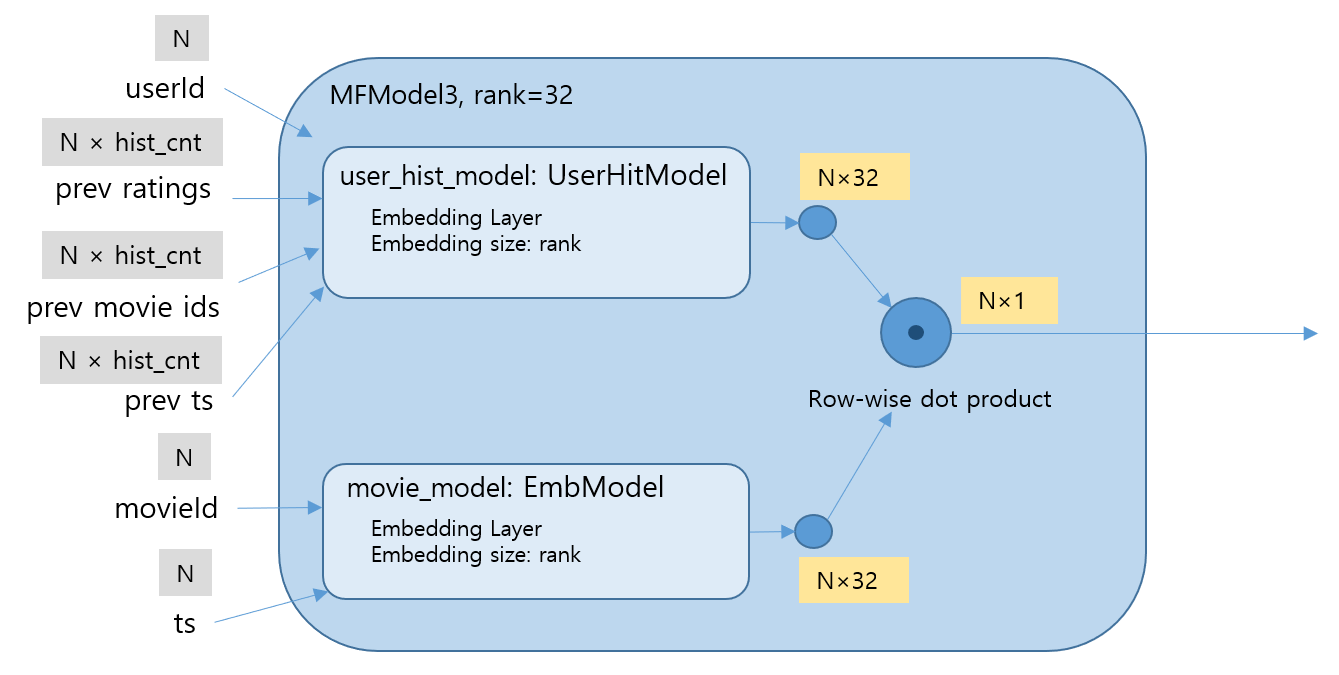

In [14]:
class MFModel3(tf.keras.Model):
    def __init__(self, user_hist_model, movie_model):
        super().__init__()
        self.user_hist_model = user_hist_model
        self.movie_model = movie_model
        self.dot = tf.keras.layers.Dot(axes=-1)
    
    def call(self, x, training=False):
        x_user = self.user_hist_model(
            x['userId'], 
            x['prev_movieIds'], 
            tf.expand_dims(x['prev_ratings'], axis=-1), 
            x['prev_ts'],
            training=training # N → N×1
        )
        x_movieId = self.movie_model(x['movieId'], x['ts'], training=training)
        return self.dot([x_user, x_movieId])

In [15]:
tf.keras.backend.clear_session()
rank = 32
collection_rank = 8
ts_mean = df_ratings['ts'].mean().astype('int64')
user_model = rcmd.EmbModel(s_userCnt.loc[s_userCnt >= 150].index.values, rank)
movie_model = rcmd.EmbModel(s_movieCnt.loc[s_movieCnt >= 100].index.values, rank)
movie_info_model = rcmd.MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)
user_hist_model = UserHistModel2(user_model, movie_info_model, rank, rnn='lstm')
mf_model3 = MFModel3(user_hist_model, movie_info_model)

test_input = {
    'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 'ts': tf.constant([ts_mean, ts_mean], dtype = tf.int64), 
    'prev_movieIds': tf.constant([[0, 1], [2, 3]]), 'prev_ratings': tf.constant([[1.0, 3.5], [2, 4]]), 
    'prev_ts': tf.constant([[ts_mean, ts_mean], [ts_mean, ts_mean]], dtype = tf.int64)
}
mf_model3(test_input)

/usr/local/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'user_hist_model2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.04426323],
       [-0.02352428]], dtype=float32)>

In [16]:
user_bins = [0, 1, 150, 500, 1000, np.inf]
s_user_type = pd.cut(
    df_test['userId'].map(df_train['userId'].value_counts()).fillna(0), bins=user_bins, right=False
).rename('userCnt')
s_user_type.value_counts()

userCnt
[0.0, 1.0)         698832
[1000.0, inf)       93169
[150.0, 500.0)      85971
[500.0, 1000.0)     55604
[1.0, 150.0)        55397
Name: count, dtype: int64

In [17]:
movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
s_movie_type = pd.cut(
    df_test['movieId'].map(df_train['movieId'].value_counts()).fillna(0), bins=movie_bins, right=False
).rename('movieCnt')
s_movie_type.value_counts()

movieCnt
[10000.0, inf)       412577
[1000.0, 5000.0)     204978
[5000.0, 10000.0)    132723
[100.0, 1000.0)      121152
[1.0, 100.0)          77940
[0.0, 1.0)            39603
Name: count, dtype: int64

In [18]:
user_mean_model = rcmd.EmbModel(s_userCnt.loc[s_userCnt > 1].index.values, rank=1)
movie_mean_model = rcmd.EmbModel(s_movieCnt.loc[s_movieCnt > 1].index.values, rank=1)
mean_model = rcmd.MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
mean_model(test_input)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.5438728],
       [3.5148087]], dtype=float32)>

In [19]:
a_model = rcmd.AdditiveModel([mf_model3, mean_model])
a_model(test_input)

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[3.4996097],
       [3.4912844]], dtype=float32)>

## Custom Train Step

다수의 이전 시청했던 영화 평가 이력을 미리 만들어 놓으면 상당한 메모리가 필요하게 됩니다. 

학습데이터를 전달하기 전에 즉 필요한 양 만큼 이전 평가 이력을 만들어 모델에 전달하려고 합니다. 

Batch 단위의 데이터에서 중에서 학습 루틴에 전달될 때, 사용자의 해당 시점 이전의 평점 이력을 생성시켜서 사용합니다.

즉, 필요한 시점에만 전체 데이터가 만들어진 상태로 전달을 시킵니다.

이렇게 하려면, compile ~ fit을 사용할 수 없고, 

데이터 처리 루틴에서 처리한 양만큼을 즉 스탭별로 학습시키는 방식으로 바꿔야 합니다. 

이를 위해, Train Step 루틴을 만듭니다.

In [24]:
# 사용자 시청 이력 로직을 파악하기 위해 학습 데이터 일부분만을 추출합니다.
i, batch_size = 0, 4
piece = df_train.iloc[i:i + batch_size]
tmp = piece['date'].values
prev_movies = list()
prev_ratings = list()

In [25]:
# 아래 구현에서 사용자의 시청이력을 만들어 내는 부분을 발췌하여 실행 시켜 봅니다.

# piece에서 사용자의 이력 정보를 가져옵니다.
hist = df_user_hist.loc[piece['userId']]
hist_cnt = 8 # hist_cnt 만큼 이전 이력을 가져오고, 만일 hist_cnt 만큼 이전 이력이 없다면, movieId는 0으로 평점은 평균으로 채워 hist_cnt 만큼이 되도록 채워줍니다.
prev_movies, prev_ratings, prev_ts = list(), list(), list()
z = np.zeros(hist_cnt, dtype=np.int64)
o = np.ones(hist_cnt, dtype=np.int64)
rating_m = np.ones(hist_cnt) * rating_train_mean
# 해당 시점의 위치 인덱스를 찾고 시점의 hist_cnt만큼의 평가 이력을 가져옵니다.
for hist_date, hist_movieId, hist_rating, hist_ts, d, ts in zip(hist['date'], hist['movieId'], hist['rating'], hist['ts'],piece['date'], piece['ts']):
    # 현재 평가시점에 해당하는 위치인덱스를 가져옵니다.
    idx = np.searchsorted(hist_date, d) # 시청 시점을 기준으로 정렬된 데이터 입니다. 이진 탐색을 통한 탐색 속도를 최소화 합니다.
    # 가져올 평가 이력의 시작 지점을 계산합니다.
    from_idx  = max(0, idx - hist_cnt)
    # 이전 평가 인덱스를 가져옵니다. 이전 이력이 없으면 Null Movie [0]를 전달합니다.
    null_hist_idx = max(0, hist_cnt - idx)
    if null_hist_idx > 0:
        # 이전 평가 인덱스를 가져옵니다. 이전 이력이 없으면 Null Movie 0을 전달합니다.
        prev_movies.append(np.hstack([z[:null_hist_idx], hist_movieId[from_idx:idx]]))
        # 이전 평가 rating을 가져옵니다. 이전 이력이 없으면 평균 편점을 전달합니다.
        prev_ratings.append(np.hstack([rating_m[:null_hist_idx], hist_rating[from_idx:idx]]))
        # 이전 평가 ts을 가져옵니다. 마지막 평가 시점을 전달 합니다.
        prev_ts.append(np.hstack([self.o[:null_hist_idx] * ts, hist_ts[from_idx:idx]]))
    else:
        prev_movies.append(hist_movieId[from_idx:idx])
        prev_ratings.append(hist_rating[from_idx:idx])
        prev_ts.append(hist_ts[from_idx:idx])

prev_ratings, prev_movies, prev_ts

([array([5., 3., 3., 5., 1., 5., 5., 5.]),
  array([5., 5., 4., 1., 1., 1., 5., 5.]),
  array([5., 5., 3., 5., 5., 3., 2., 5.]),
  array([5., 3., 3., 5., 1., 5., 5., 5.])],
 [array([  80, 1172, 1276,  111,   36, 1719, 1263, 2025]),
  array([1221, 1213, 1150, 1120, 2312, 1961, 1721, 1247]),
  array([1196,  260, 2232, 1748, 2640, 1965, 1210,   32]),
  array([  80, 1172, 1276,  111,   36, 1719, 1263, 2025])],
 [array([944248943000000000, 944248943000000000, 944248943000000000,
         944249008000000000, 944249008000000000, 944249008000000000,
         944249008000000000, 944249008000000000]),
  array([944250121000000000, 944250121000000000, 944250121000000000,
         944250121000000000, 944250182000000000, 944250182000000000,
         944250182000000000, 944250182000000000]),
  array([943228696000000000, 943228696000000000, 943228696000000000,
         943228697000000000, 943228697000000000, 943228697000000000,
         943228858000000000, 943228858000000000]),
  array([94424894300000

In [27]:
from sklearn.metrics import mean_squared_error

def train_single(a_model, df_train, hist_cnt = 8, batch_size = 1024):
    # df_train의 위치 인덱스를 batch_size 만큼씩 나눕니다.
    pos = np.hstack([np.arange(0, len(df_train), batch_size), [len(df_train) - batch_size]])
    # 데이터가 특정 범주로 편중이 되면 학습이 잘 되지 않습니다. 
    # 이룰 방지하기 위해 순서를 섞어 줍니다.
    np.random.shuffle(pos)
    pbar = tqdm(pos)
    metric_mse = tf.keras.metrics.Mean()
    metric_loss = tf.keras.metrics.Mean()
    
    mse = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    # Custom Train Step
    # tf.function 데코레이터 내부에 텐서를 전달할 때에는 텐서의 스펙을 줘야 제대로된 최적화가 됩니다.
    @tf.function(
        input_signature = [
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # userId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # moveId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # ts: N
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_movieIds: Nx8
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.float32), # prev_ratings: Nx8
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_ts: Nx8
            tf.TensorSpec(shape=(None,), dtype=tf.float32) # ratings: N
        ]
    )
    def train_step(userId, movieId, ts, prev_movieIds, prev_ratings, prev_ts, rating):
        # Loss의 경사도를 계산하기 위해, 
        # Loss를 구하기 위한 연산들에서 모델들의 가중치(weight)의 경사도를 기록하게 합니다.
        with tf.GradientTape() as tape:
            prd = a_model({
                'userId': userId, 
                'movieId': movieId, 
                'ts': ts,
                'prev_movieIds': prev_movieIds, 
                'prev_ratings': prev_ratings,
                'prev_ts': prev_ts
            }, training=True)
            mse_ = mse(rating, prd)
            regularization_loss = tf.reduce_sum(a_model.losses)
            loss = mse_ + regularization_loss
        metrics = {
            'mse': mse_,
            'loss': loss,
            'regularization_loss': regularization_loss
        }
        variables = a_model.trainable_variables
        # 기록된 모델에 있는 가중치의 경사도를 가져옵니다.
        gradients = tape.gradient(loss, variables)
        # 최적화 모듈에 경사도를 전달하여 모델에 있는 가중치를 업데이트합니다.
        optimizer.apply_gradients(zip(gradients, variables))
        return metrics
    df_train = df_train.sample(frac = 1)
    z = np.zeros(hist_cnt, dtype=np.int64)
    o = np.ones(hist_cnt, dtype=np.int64)
    for n, i in enumerate(pbar):
        piece = df_train.iloc[i:i + batch_size]
        tmp = piece['date'].values
        prev_movies, prev_ratings, prev_ts = list(), list(), list()
        hist = df_user_hist.loc[piece['userId']]
        # 해당 시점의 위치 인덱스를 찾고 시점의 hist_cnt만큼의 평가 이력을 가져옵니다.
        for hist_date, hist_movieId, hist_rating, hist_ts, d, ts in zip(hist['date'], hist['movieId'], hist['rating'], hist['ts'], piece['date'], piece['ts']):
            # 현재 평가시점에 해당하는 위치인덱스를 가져옵니다.
            idx = np.searchsorted(hist_date, d) # 시청 시점을 기준으로 정렬된 데이터 입니다. 이진 탐색을 통한 탐색 속도를 최소화 합니다.
            # 가져올 평가 이력의 시작 지점을 계산합니다.
            from_idx  = max(0, idx - hist_cnt)
            null_hist_idx = max(0, hist_cnt - idx)
            if null_hist_idx > 0:
                # 이전 평가 인덱스를 가져옵니다. 이전 이력이 없으면 Null Movie 0을 전달합니다.
                prev_movies.append(np.hstack([z[:null_hist_idx], hist_movieId[from_idx:idx]]))
                # 이전 평가 rating을 가져옵니다. 이전 이력이 없으면 평균 편점을 전달합니다.
                prev_ratings.append(np.hstack([rating_m[:null_hist_idx], hist_rating[from_idx:idx]]))
                # 이전 평가 ts을 가져옵니다. 마지막 평가 시점을 전달 합니다.
                prev_ts.append(np.hstack([o[:null_hist_idx] * ts, hist_ts[from_idx:idx]]))
            else:
                prev_movies.append(hist_movieId[from_idx:idx])
                prev_ratings.append(hist_rating[from_idx:idx])
                prev_ts.append(hist_ts[from_idx:idx])

        # 사용자 / 영화 / 추출한 평가이력 / 점수를 train_step에 전달합니다.
        loss = train_step(
            tf.constant(piece['userId'], dtype=tf.int64),
            tf.constant(piece['movieId'], dtype=tf.int64),
            tf.constant(piece['ts'], dtype=tf.int64),
            tf.constant(prev_movies, dtype=tf.int64),
            tf.constant(prev_ratings, dtype=tf.float32),
            tf.constant(prev_ts, dtype=tf.int64),
            tf.constant(piece['rating'], dtype=tf.float32)
        )
        metric_mse.update_state(loss['mse'])
        metric_loss.update_state(loss['loss'])
        pbar.set_description("mse {:.3f}, loss {:.3f}".format(metric_mse.result().numpy(), metric_loss.result().numpy()))
        
def predict_single_test(a_model, df_test, batch_size):
    pos = np.hstack([np.arange(0, len(df_test),batch_size)])
    prds = []
    pbar = tqdm(pos)
    for n, i in enumerate(pbar):
        piece = df_test.iloc[i:i + batch_size]
        hist = df_user_hist.loc[piece['userId']]
        tmp = piece['date'].values
        prev_movies = list()
        prev_ratings = list()
        for hist_date, hist_movieId, hist_rating, hist_ts, d, ts in zip(hist['date'], hist['movieId'], hist['rating'], hist['ts'], piece['date'], piece['ts']):
            idx = np.searchsorted(hist_date, d)
            from_idx  = max(0, idx - hist_cnt)
            null_hist_idx = max(0, hist_cnt - idx)
            if null_hist_idx > 0:
                # 이전 평가 인덱스를 가져옵니다. 이전 이력이 없으면 Null Movie 0을 전달합니다.
                prev_movies.append(np.hstack([z[:null_hist_idx], hist_movieId[from_idx:idx]]))
                # 이전 평가 rating을 가져옵니다. 이전 이력이 없으면 평균 편점을 전달합니다.
                prev_ratings.append(np.hstack([rating_m[:null_hist_idx], hist_rating[from_idx:idx]]))
            else:
                prev_movies.append(hist_movieId[from_idx:idx])
                prev_ratings.append(hist_rating[from_idx:idx])
        prd = a_model({
            'userId': tf.constant(piece['userId']), 
            'movieId': tf.constant(piece['movieId']), 
            'ts': tf.constant(piece['ts']), 
            'prev_movieIds': tf.constant(prev_movies), 
            'prev_ratings': tf.constant(prev_ratings),
            'prev_ts': tf.constant(prev_ts)
        })
        prds.append(prd.numpy())
    return np.squeeze(np.vstack(prds))

# 단일 Process 버젼의 학습 루틴입니다. 
# 본 노트에서는 실행을 완료 시켜 전체의 결과를 뽑아 냈지만,
# 이후에 나오는 병렬화 버젼과 동일한 모델을 동일한 데이터로 학습시키는 것입니다.
# 따라서, 이 모델의 학습 결과를 확인하기 위함이라면,
# 본 셀은 생략하고 아래의 병렬화 과정을 사용하면 됩니다.

verbose = True
epochs = 10
hist_cnt = 8
# 병렬화 효율의 극대화를 하고자 한다면 GPU 메모리가 허용하는 수준의 batch size를 증가시키면 됩니다.
# batch_size=1024 세팅은 GPU 메모리 크기가 4GB를 기준으로 만든 것입니다.
batch_size = 1024

mse_test, mse_by_userCnt, mse_by_movieCnt = list(), list(), list()
for i in range(epochs):
    train_single(a_model, df_train, hist_cnt, batch_size)
    prds = predict_single_test(a_model, df_test, batch_size)
    if verbose:
        # 테스트셋의 성능을 구합니다.
        mse_test.append(mean_squared_error(df_test['rating'], prds))
        # 테스트셋 성능을 묶어 데이터프레임을 만듭니다.
        df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
        # 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
        mse_by_userCnt.append(
            df_prd.groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )
        # 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
        mse_by_movieCnt.append(
            df_prd.groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
        )
        # 종합하여 하나의 데이터프레임으로 만듭니다.
        df_result = pd.concat([
            pd.DataFrame({('', 'test'): mse_test}),
            pd.concat(mse_by_userCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
            ).T,
            pd.concat(mse_by_movieCnt, axis=1).pipe(
                lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
            ).T
        ], axis=1)
        df_result.index = np.arange(1, len(df_result) + 1)
        df_result.name = 'epoch'
        clear_output()
        display(df_result)

mse 0.775, loss 0.775:   0%|                                                       | 49/30286 [00:10<1:48:26,  4.65it/s]


KeyboardInterrupt: 

In [28]:
del a_model, mean_model, movie_mean_model, user_mean_model, mf_model3, movie_info_model, movie_model, user_hist_model, user_model

## 히스토리 데이터 처리 병렬화 버젼

병렬처리를 통한 사용자가 이전에 평가한 N개의 이력을 가져오게 루틴을 구성했습니다.

이렇게하여 CPU에서 처리하는 이력 추출 작업에 의한 Bottle Neck 현상에 대응할 수 있습니다.

약 15% 정도의 실행 효율 증가를 얻을 수 있습니다.

In [29]:
from multiprocessing import Process, Queue
# 이전 히스토리를 가져오는 부분을 Process화 합니다.
class BatchWoker(Process):
    def __init__(self, q, df, df_hist, pos, hist_cnt, batch_size, default_rating):
        self.q = q
        self.hist_cnt = hist_cnt
        self.batch_size = batch_size
        self.df = df
        self.df_hist = df_hist
        self.pos = pos
        self.z = np.zeros(hist_cnt, dtype=np.int64)
        self.o = np.ones(hist_cnt, dtype=np.int64)
        self.rating_m = np.ones(hist_cnt) * default_rating
        super().__init__()
    def run(self):
        for i in self.pos:
            piece = self.df.iloc[i:i + self.batch_size]
            hist = self.df_hist.loc[piece['userId']]
            prev_movies, prev_ratings, prev_ts = list(), list(), list()
            # 해당 시점의 위치 인덱스를 찾고 시점의 hist_cnt만큼의 평가 이력을 가져옵니다.
            for hist_date, hist_movieId, hist_rating, hist_ts, d, ts in zip(hist['date'], hist['movieId'], hist['rating'], hist['ts'],piece['date'], piece['ts']):
                # 현재 평가시점에 해당하는 위치인덱스를 가져옵니다.
                idx = np.searchsorted(hist_date, d)
                # 가져올 평가 이력의 시작 지점을 계산합니다.
                from_idx  = max(0, idx - self.hist_cnt)
                null_hist_idx = max(0, self.hist_cnt - idx)
                if null_hist_idx > 0:
                    # 이전 평가 인덱스를 가져옵니다. 이전 이력이 없으면 Null Movie 0을 전달합니다.
                    prev_movies.append(np.hstack([self.z[:null_hist_idx], hist_movieId[from_idx:idx]]))
                    # 이전 평가 rating을 가져옵니다. 이전 이력이 없으면 평균 편점을 전달합니다.
                    prev_ratings.append(np.hstack([self.rating_m[:null_hist_idx], hist_rating[from_idx:idx]]))
                    # 이전 평가 ts을 가져옵니다. 마지막 평가 시점을 전달 합니다.
                    prev_ts.append(np.hstack([self.o[:null_hist_idx] * ts, hist_ts[from_idx:idx]]))
                else:
                    prev_movies.append(hist_movieId[from_idx:idx])
                    prev_ratings.append(hist_rating[from_idx:idx])
                    prev_ts.append(hist_ts[from_idx:idx])
            batch = (piece['userId'], piece['movieId'], piece['ts'], prev_movies, prev_ratings, prev_ts, piece['rating'])
            self.q.put(batch)
        self.q.put(None) # 할당량을 채웠을 경우에 None을 반환합니다.

In [30]:
def hist_set_iter(df, df_hist, hist_cnt, batch_size, pbar=None, shuffle=True, n_job=4, queue_size=16, default_rating=0.0, equal_batch_size=True):
    """
        Multiprocessing을 통해 Batch 데이터를 만들어 내는 Iterator

        df: pd.DataFrame
            rating 데이터프레임
        df_hist: pd.DataFrame
            이력 데이터
        pos: list
            위치 인덱스 리스트
        hist_cnt: int
            이전 평가 이력 수
        batch_size: int
            배치(Batch) 사이즈
        pbar: Tqdm
            Progress 표시기
        shuffle: bool
            데이터를 섞음 여부
        n_job: int
            Process 수
        queue_size: int
            Queue 사이즈
        default_rating: float
            이력 평점이 결측일 경우의 대체할 평점
        equal_batch_size: bool
            마지막 부분의 배치사이즈를 동일하게 맞출지 여부
    """
    if len(df) % batch_size != 0 and equal_batch_size:
        # 전체셋 크기가 batch_size에 나누어 떨어지지 않으면
        # 동일한 Batch 사이즈를 위해 마지막은 끝에서 batch_size만큼 뺀 위치 부터 가져옵니다.
        pos = np.hstack([np.arange(0, len(df) - batch_size, batch_size), [len(df) - batch_size]])
    else:
        pos = np.arange(0, len(df), batch_size)
    chunk = (len(pos) + n_job - 1) // n_job
    if shuffle:
        np.random.shuffle(pos)
    # Work Process 에서 작업한 결과를 저장할 Queue입니다.
    q = Queue(queue_size)
    # n_jobs 만큼 Worker를 생성합니다.
    workers = list()
    for i in range(0, len(pos), chunk):
        workers.append(BatchWoker(q, df, df_hist, pos[i: i + chunk], hist_cnt, batch_size, default_rating))
        workers[-1].start()
    job_finished = 0
    if pbar is not None:
        pbar.total = len(pos)
    while(True):
        val = q.get()
        if val == None: # Worker가 작업을 마치면 None을 반환합니다.
            job_finished +=1 # 작업이 끝난 Worker 카운트
            if job_finished == len(workers): # 모든 Worker가 작업을 끝냈다면 중지
                break
            continue
        yield(val)
        if pbar is not None:
            pbar.update(1)

In [31]:
from sklearn.metrics import mean_squared_error

def train(a_model, df_train, hist_cnt = 8, batch_size = 1024, n_job = 4):
    # df_train의 위치 인덱스를 batch_size 만큼씩 나눕니다.
    metric_mse = tf.keras.metrics.Mean()
    metric_loss = tf.keras.metrics.Mean()
    
    mse = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    # Custom Train Step
    @tf.function(
        input_signature = [
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # userId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # moveId: N
            tf.TensorSpec(shape=(None, ), dtype=tf.int64), # ts: N
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_movieIds: Nx8
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.float32), # prev_ratings: Nx8
            tf.TensorSpec(shape=(None, hist_cnt), dtype=tf.int64), # prev_ts: Nx8
            tf.TensorSpec(shape=(None,), dtype=tf.float32) # ratings: N
        ]
    )
    def train_step(userId, movieId, ts, prev_movieIds, prev_ratings, prev_ts, rating):
        # Loss의 경사도를 계산하기 위해, 
        # Loss를 구하기 위한 연산들에서 모델들의 가중치(weight)의 경사도를 기록하게 합니다.
        with tf.GradientTape() as tape:
            prd = a_model({
                'userId': userId, 
                'movieId': movieId, 
                'ts': ts,
                'prev_movieIds': prev_movieIds, 
                'prev_ratings': prev_ratings,
                'prev_ts': prev_ts,
            }, training=True)
            mse_ = mse(rating, prd)
            regularization_loss = tf.reduce_sum(a_model.losses)
            loss = mse_ + regularization_loss
        metrics = {
            'mse': mse_,
            'loss': loss,
            'regularization_loss': regularization_loss
        }
        variables = a_model.trainable_variables
        # 기록된 모델에 있는 가중치의 경사도를 가져옵니다.
        gradients = tape.gradient(loss, variables)
        # 최적화 모듈에 경사도를 전달하여 모델에 있는 가중치를 업데이트합니다.
        optimizer.apply_gradients(zip(gradients, variables))
        return metrics

    with tqdm() as pbar:
        for i in hist_set_iter(
            df_train.sample(frac = 1), df_user_hist, hist_cnt, batch_size, pbar, shuffle=False, n_job = n_job, default_rating=rating_train_mean, equal_batch_size=True
        ):
            # 사용자 / 영화 / 추출한 평가이력 / 점수를 train_step에 전달합니다.
            loss = train_step(
                tf.constant(i[0], dtype=tf.int64), # userId
                tf.constant(i[1], dtype=tf.int64), # movieID
                tf.constant(i[2], dtype=tf.int64), # ts
                tf.constant(i[3], dtype=tf.int64), # prev_movieIds
                tf.constant(i[4], dtype=tf.float32), # prev_ratings
                tf.constant(i[5], dtype=tf.int64), # prev_ts
                tf.constant(i[6], dtype=tf.float32), # rating
            )
            metric_mse.update_state(loss['mse'])
            metric_loss.update_state(loss['loss'])
            pbar.set_description("mse {:.3f}, loss {:.3f}".format(metric_mse.result().numpy(), metric_loss.result().numpy()))

def predict_test(a_model, df_test, hist_cnt = 8, batch_size = 1024):
    prds = list()
    with tqdm() as pbar:
        for i in hist_set_iter(df_test, df_user_hist, hist_cnt, batch_size, pbar, shuffle=False, n_job=1, default_rating=rating_train_mean, equal_batch_size=False):
            prd = a_model({
                'userId': tf.constant(i[0], dtype=tf.int64), 
                'movieId': tf.constant(i[1], dtype=tf.int64), 
                'ts': tf.constant(i[2], dtype=tf.int64),
                'prev_movieIds': tf.constant(i[3], dtype=tf.int64), 
                'prev_ratings': tf.constant(i[4], dtype=tf.float32),
                'prev_ts': tf.constant(i[5], dtype=tf.int64),
            })
            prds.append(prd.numpy())
    return np.squeeze(np.vstack(prds))

In [ ]:
# mf3.pkl 이 없으면 학습을 하고, 학습 산출물를 mf3.pkl에 저장합니다.
# mf3.pkl 이 있으면 학습 산출물을 불러오고, 결과를 출력하고, 기존의 모델을 불러옵니다.
model_filename = os.path.join('model', 'mf3.pkl')
"""
if not os.path.exists(model_filename):
    o = gdown.download("https://drive.google.com/uc?id=18jDrElizg4ww_7bfKnuWwc3oo5sPLXwY", quiet=False)
    os.rename(o, model_filename)
"""
if not os.path.isfile(model_filename):
    rank = 32
    # 모델 인스턴스를 만듭니다.
    tf.keras.backend.clear_session()
    rank = 32
    collection_rank = 8
    rnn = 'lstm'
    user_idx = s_userCnt.loc[s_userCnt >= 150].index.values
    movie_idx = s_movieCnt.loc[s_movieCnt >= 100].index.values
    user_model = rcmd.EmbModel(user_idx, rank)
    movie_model = rcmd.EmbModel(movie_idx, rank)
    movie_info_model = rcmd.MovieInfoModel(df_movieinfo, movie_model, {'collection': collection_rank}, rank)
    user_hist_model = UserHistModel2(user_model, movie_info_model, rank, rnn=rnn)
    mf_model3 = MFModel3(user_hist_model, movie_info_model)

    user_mean_idx = s_userCnt.loc[s_userCnt >= 1].index.values
    movie_mean_idx = s_movieCnt.loc[s_movieCnt >= 1].index.values
    user_mean_model = rcmd.EmbModel(user_mean_idx, rank=1)
    movie_mean_model = rcmd.EmbModel(movie_mean_idx, rank=1)
    mean_model = rcmd.MeanModel(rating_train_mean, user_mean_model, movie_mean_model)
    
    a_model = rcmd.AdditiveModel([mf_model3, mean_model])
    user_bins = [0, 1, 150, 500, 1000, np.inf]
    movie_bins = [0, 1, 100, 1000, 5000, 10000, np.inf]
    epochs, hist_cnt, verbose = 10, 8, True
    # 병렬화 효율의 극대화를 하고자 한다면 GPU 메모리가 허용하는 수준의 batch size를 증가시키면 됩니다.
    # batch_size=1024 세팅은 GPU 메모리 크기가 4GB를 기준으로 만든 것입니다.
    batch_size = 1024
    mse_test, mse_by_userCnt, mse_by_movieCnt = list(), list(), list()
    for i in range(epochs):
        train(a_model, df_train, hist_cnt, batch_size)
        prds = predict_test(a_model, df_test, hist_cnt, batch_size)
        if verbose:
            # 테스트셋의 성능을 구합니다.
            mse_test.append(mean_squared_error(df_test['rating'], prds))
            # 테스트셋 성능을 묶어 데이터프레임을 만듭니다.
            df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
            # 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
            mse_by_userCnt.append(
                df_prd.groupby(s_user_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
            )
            # 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
            mse_by_movieCnt.append(
                df_prd.groupby(s_movie_type).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
            )
            # 종합하여 하나의 데이터프레임으로 만듭니다.
            df_result = pd.concat([
                pd.DataFrame({('', 'test'): mse_test}),
                pd.concat(mse_by_userCnt, axis=1).pipe(
                    lambda x: x.set_index(pd.MultiIndex.from_product([['userCnt'], x.index.tolist()]))
                ).T,
                pd.concat(mse_by_movieCnt, axis=1).pipe(
                    lambda x: x.set_index(pd.MultiIndex.from_product([['movieCnt'], x.index.tolist()]))
                ).T
            ], axis=1)
            df_result.index = np.arange(1, len(df_result) + 1)
            df_result.name = 'epoch'
            clear_output()
            display(df_result)
    # 학습 산출물을 저장합니다.
    with open(model_filename, 'wb') as f:
        pickle.dump({
            'rank': rank,
            'collection_rank': collection_rank,
            'rating_train_mean': rating_train_mean,
            'user_idx': user_idx,
            'movie_idx': movie_idx,
            'user_mean_idx': user_mean_idx,
            'movie_mean_idx': movie_mean_idx,
            'movieInfo': df_movieinfo,
            'result': df_result,
            'weights': a_model.get_weights(),
            'rnn': rnn,
            'hist_cnt': hist_cnt
        }, f)
else:
    with open(model_filename, 'rb') as f:
        mf3 = pickle.load(f)
    display(mf3['result'])
    # 모델을  만듭니다.
    tf.keras.backend.clear_session()
    rank = mf3['rank']
    collection_rank = mf3['collection_rank']
    hist_cnt = mf3['hist_cnt']
    user_model = rcmd.EmbModel(mf3['user_idx'], rank)
    movie_model = rcmd.EmbModel(mf3['movie_idx'], rank)
    movie_info_model = rcmd.MovieInfoModel(mf3['movieInfo'], movie_model, {'collection': collection_rank}, rank)
    user_hist_model2 = UserHistModel2(user_model, movie_info_model, rank, rnn=mf3["rnn"])
    mf_model3 = MFModel3(user_hist_model2, movie_info_model)
    
    user_mean_model = rcmd.EmbModel(mf3['user_mean_idx'], rank=1)
    movie_mean_model = rcmd.EmbModel(mf3['movie_mean_idx'], rank=1)
    mean_model = rcmd.MeanModel(mf3['rating_train_mean'], user_mean_model, movie_mean_model)
    
    a_model = rcmd.AdditiveModel([mf_model3, mean_model])
    
    # 모델을 호출을 하면 구성된 모델의 Weights가 생성됩니다.
    a_model({'userId': tf.constant([1, 2]), 'movieId': tf.constant([1, 5]), 'ts': tf.constant([0, 0], dtype = tf.int64),
            'prev_movieIds': tf.constant([[0, 1], [2, 3]]), 'prev_ratings': tf.constant([[1.0, 3.5], [2.0, 2.5]]), 
            'prev_movieIds': tf.constant([[0, 1], [2, 3]], dtype = tf.int64), 'prev_ts': tf.constant([[0, 0], [0, 0]], dtype = tf.int64) })
    
    # 저장해두었던 가중치를 설정합니다.
    a_model.set_weights(mf3['weights'])
    display(mf3['result'])
    del mf3

userCnt                                              \
        test [0.0, 1.0) [1.0, 150.0) [150.0, 500.0) [500.0, 1000.0)   
1   0.660527   0.674153     0.660524       0.642691        0.605635   
2   0.657591   0.670374     0.658861       0.642189        0.605762   
3   0.652943   0.665483     0.653418       0.638110        0.601791   
4   0.648564   0.660844     0.650207       0.631876        0.598616   
5   0.644260   0.656704     0.645484       0.627666        0.593661   
6   0.642373   0.656350     0.644049       0.623300        0.586651   
7   0.641047   0.654117     0.642709       0.623124        0.587280   
8   0.637653   0.649886     0.639635       0.621453        0.586680   
9   0.637403   0.649797     0.638089       0.620662        0.585467   
10  0.635127   0.648394     0.636063       0.618333        0.581052   

                   movieCnt                                                \
   [1000.0, inf) [0.0, 1.0) [1.0, 100.0) [100.0, 1000.0) [1000.0, 5000.0)   
1       0.607540   0.859878     0.804933        0.666185         0.655014   
2       0.606093   0.867012     0.802548        0.663933         0.653118   
3       0.602813   0.887073     0.801959        0.656287         0.645925   
4       0.600687   0.903352     0.798649        0.653565         0.639760   
5       0.595708   0.906682     0.794874        0.647969         0.634785   
6       0.587404   0.880352     0.788422        0.648347         0.635394   
7       0.590659   0.902945     0.784875        0.646035         0.633023   
8       0.590096   0.908393     0.782752        0.640108         0.628886   
9       0.590475   0.916303     0.782970        0.640944         0.628729   
10      0.582821   0.898838     0.780667        0.638652         0.627652   

                                     
   [5000.0, 10000.0) [10000.0, inf)  
1           0.619082       0.628521  
2           0.616611       0.623647  
3           0.611054       0.618298  
4           0.605366       0.612556  
5           0.601904       0.607862  
6           0.602098       0.606610  
7           0.600279       0.604374  
8           0.596335       0.601182  
9           0.596093       0.599691  
10          0.595294       0.597811

In [27]:
# 평가 데이터의 예측 결과를 뽑아냅니다.
prds = predict_test(a_model, df_test, hist_cnt, 1024)
df_prd = pd.DataFrame({'rating': df_test['rating'], 'prds': prds})
# 학습셋의 사용자 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_user_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)
# 학습셋의 영화 평점수 구간별 테스트셋의 성능을 구합니다.
display(
    df_prd.groupby(s_movie_type, observed=True).apply(lambda x: mean_squared_error(x['rating'], x['prds']))
)

100%|█████████████████████████████████████████████████████████████████████████████████| 966/966 [00:35<00:00, 27.47it/s]


userCnt
[0.0, 1.0)         0.648394
[1.0, 150.0)       0.636063
[150.0, 500.0)     0.618333
[500.0, 1000.0)    0.581052
[1000.0, inf)      0.582821
dtype: float64

movieCnt
[0.0, 1.0)           0.898838
[1.0, 100.0)         0.780667
[100.0, 1000.0)      0.638652
[1000.0, 5000.0)     0.627652
[5000.0, 10000.0)    0.595294
[10000.0, inf)       0.597811
dtype: float64

In [28]:
# 영화 임베딩을 프로젝션해봅니다.

from tensorboard.plugins import projector

# 프로젝션 데이터가 저장될 경로를 만듭니다.
log_dir='logs/m32m_3/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# 메타데이터를 저장합니다.
known = []
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in s_movieCnt.loc[s_movieCnt > 100].index:
        if i in m32m['movie_info_kr']:
            f.write("{}\n".format(df_movie.loc[i, 'title']))
            known.append(i)

# 내용을 저장합니다.
weights =  tf.Variable(
    movie_info_model(tf.constant(known), tf.constant(df_ratings.groupby(['movieId'])['ts'].mean().loc[known].astype('int64'), dtype=tf.int64))
)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
# %tensorboard --logdir logs/m32m_3/ --bind_all

# MLOps

새로운 사용자와 아이템이 등장하면, 이에 대응한 임베딩들의 학습과

최근 데이터를 반영한 최근의 사용자와 아이템에서 나오는 트렌드를 모델에 반영을 위해 지속적인 재학습이 필요합니다.

이런 맥락에서 MLOps에 대한 개념이 일찍 감치 등장한 분야가 바로 추천 시스템입니다. 

이에 대한 전반적인 개념과 사례에 대해 소개 드립니다.

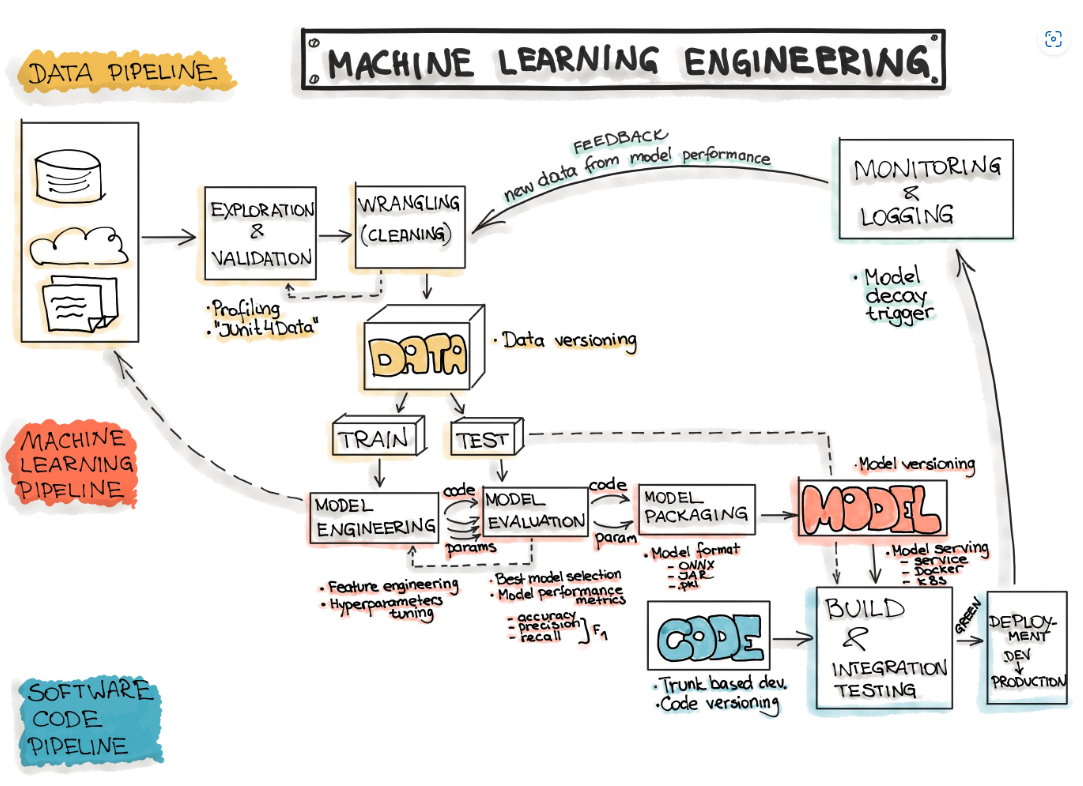

※ [출처] [MLOps.org](https://ml-ops.org/)